In [93]:
#import all relevant packages
import torch, torchvision
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import os.path
from os import path
import torch, torchvision
from prettytable import PrettyTable
plt.rcParams["figure.figsize"] = (20,10)

In [94]:
#DATA WRANGLING

# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

transform_base = [transforms.ToTensor()]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ] + transform_base)

transform_test = transforms.Compose(transform_base)
transform_train = transforms.RandomChoice([transform_train, transform_test])

#'~/data/SVHN'
train_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='train',
                             download=True, transform=transform_train)

#'~/data/SVHN'
test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=True, transform=transform_test)

SVHN_train_loader = torch.utils.data.DataLoader(train_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
SVHN_test_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)


CIFAR10_trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_SVHN, shuffle=True, num_workers=2)

#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_SVHN, shuffle=False, num_workers=2)

#'~/data/cifar100'
CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
                                       download=True, transform=transform_train)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_SVHN,
                                         shuffle=False)
#'~/data/cifar100'
CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_SVHN,
                                         shuffle=False)

Using downloaded and verified file: /Users/moreez/data/SVHN/train_32x32.mat
Using downloaded and verified file: /Users/moreez/data/SVHN/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [95]:
def vggNet(sz, out):
    layers = nn.Sequential()
    layers.add_module('0', nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('1', nn.ReLU())
    layers.add_module('2', nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
    layers.add_module('3', nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('4', nn.ReLU())
    layers.add_module('5', nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
    layers.add_module('6', nn.Conv2d(128, sz, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('7', nn.ReLU())
    layers.add_module('8', nn.Conv2d(sz, sz, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('9', nn.ReLU())
    layers.add_module('10', nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
    layers.add_module('11', nn.Conv2d(sz, sz, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('12', nn.ReLU())
    layers.add_module('13', nn.Conv2d(sz, sz, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('14', nn.ReLU())
    layers.add_module('15', nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
    layers.add_module('16', nn.Conv2d(sz, sz, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('17', nn.ReLU())
    layers.add_module('18', nn.Conv2d(sz, sz, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
    layers.add_module('19', nn.ReLU())
    layers.add_module('20', nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
    # layers.add_module('21', nn.AdaptiveAvgPool2d(output_size=(7, 7)))
    layers.add_module('21', nn.Flatten())
    layers.add_module('22', nn.Dropout(p=0.5, inplace=False))
    layers.add_module('23', nn.Linear(in_features=sz, out_features=sz, bias=True))
    layers.add_module('24', nn.ReLU())
    layers.add_module('25', nn.Dropout(p=0.5, inplace=False))
    layers.add_module('26', nn.Linear(in_features=sz, out_features=sz, bias=True))
    layers.add_module('27', nn.ReLU())
    layers.add_module('28', nn.Linear(in_features=sz, out_features=out, bias=True))
    return layers

In [96]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

## uncertainties

In [240]:
def get_uncerts(dataset, seed, trained=False):  
    
    
    widths = ['512', '128','64','32','16', '8', '4', '2']

    avg_unc = []
    lastlayer_unc = []
    firstlayers_unc = []
    
    for width in widths:
        #if width == '16':
        #    accur = '80'
        #elif width in ['8','4','2']:
        #    DATAPATH = '/Users/moreez/Desktop/BcThesis/VGG/exx/Hess/bestHess/{}bes_ckpt_seed11.pth'.format(width)
        #else:
        #    accur = '90'
        #if path.exists('/Users/moreez/Desktop/BcThesis/VGG/exx/Hess/bestHess/{}vggHessian_prec00001_seed11_accur{}.pth'.format(width, accur)):
        #        print(width)    
        if trained:
            DATAPATH = '/Users/moreez/Desktop/BcThesis/VGG/NASex/checkpoint/{}/trainedHess/{}trainedHessian_prec00001_seed{}.pth'.format(dataset, width, seed)
        else:    
            DATAPATH = '/Users/moreez/Desktop/BcThesis/VGG/NASex/checkpoint/{}/untrainedHess/{}untrainedHessian_prec00001_seed{}.pth'.format(dataset, width, seed)
        #print(DATAPATH)
        hess = torch.load(DATAPATH, map_location=torch.device('cpu')) 
        temp = []
        tempfirst = []
        for i, tnsr in enumerate(hess):
            if i%2 == 0:
                temp.append(torch.mean(tnsr).item())
        for i in [0, 2]:
            tempfirst.append(torch.mean(hess[i]).item())
            
        avg_unc.append(np.mean(temp))
        lastlayer_unc.append(torch.mean(hess[-2]).item())
        firstlayers_unc.append(np.mean(tempfirst))
        

    #print(avg_unc)
    #print(lastlayer_unc)
    return avg_unc, lastlayer_unc, firstlayers_unc


# accuracys

In [99]:
def get_acc(dataset, seed, testloader):    
    widths = [512, 128, 64, 32, 16, 8, 4, 2]
    #widths = [8, 4, 2]
    acc = []
    for width in widths:
        model = vggNet(sz=width, out=100)
        if path.exists('/Users/moreez/Desktop/BcThesis/VGG/NASex/checkpoint/{}/trainedNets/{}best_ckpt_seed{}.pth'.format(dataset, width, seed)):
                print(width)    
                DATAPATH = '/Users/moreez/Desktop/BcThesis/VGG/NASex/checkpoint/{}/trainedNets/{}best_ckpt_seed{}.pth'.format(dataset, width, seed)

        weights = torch.load(DATAPATH, map_location=torch.device('cpu')) 
        #print(weights.keys())
        keyss = weights.keys()
        topop = []
        for elem in keyss:
            if 'shape' in elem:
                topop.append(elem)
        for key in topop:
            weights.pop(key)
        #print(weights.keys())
        model.load_state_dict(weights, strict=True)
        model.eval()
        acctemp = []
        max_len = len(testloader)
        for batch_idx, (x, y) in enumerate(testloader):
                output = model(x)
                accuracy = get_accuracy(output, y)
                if batch_idx % 30 == 0:
                    print(
                        "Batch {}/{} \t".format(batch_idx, max_len) + 
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )
                acctemp.append(accuracy)

        avg_acc = np.mean(acctemp)
        acc.append(avg_acc)

    #print(acc)
    return acc




In [100]:
widths = [512, 128, 64, 32, 16, 8, 4, 2]
#widths = [8, 4, 2]

weightsize_svhn = []
for width in widths:
    model = vggNet(sz=width, out=100)
    if path.exists('/Users/moreez/Desktop/BcThesis/VGG/SVHN/{}best_ckpt_seed11_.pth'.format(width)):
            print(width)    
            DATAPATH = '/Users/moreez/Desktop/BcThesis/VGG/SVHN/{}best_ckpt_seed11_.pth'.format(width)
    
    weights = torch.load(DATAPATH, map_location=torch.device('cpu')) 
    #model.load_state_dict(weights)
    #model.eval()
    sztemp = []
    for k in weights.keys():
        if 'weight' in k:
            sztemp.append(torch.mean(weights[k]).item())
    
    weightsize_svhn.append(np.mean(sztemp))
    
print(weightsize_svhn)
#print(lastlayer_unc)







512
128
64
32
16
8
4
2
[0.00044406672003043985, -4.600786765381186e-05, -0.000898550235433504, -0.003817551596016115, -0.006213179101574828, -0.012518313861536708, 0.008344983042661624, 0.03588800712896045]


In [101]:
#plt.plot(wd[::-1], svhnacc20[::-1])
#plt.plot(wd[::-1], svhnacc21[::-1])
#plt.plot(wd[::-1], svhnacc22[::-1])
#plt.plot(wd[::-1], cifar10acc23[::-1])
#plt.plot(wd[::-1], cifar10acc24[::-1])
#plt.show()

In [102]:
#cifar10acc20 = get_acc('CIFAR10', 20, CIFAR10_test_loader)
#svhnacc20 = get_acc('SVHN', 20, SVHN_test_loader)
cifar100acc20 = get_acc('CIFAR100', 20, CIFAR100_test_loader)

512
Batch 0/79 	Accuracy 60%
Batch 30/79 	Accuracy 58%
Batch 60/79 	Accuracy 50%
128
Batch 0/79 	Accuracy 56%
Batch 30/79 	Accuracy 52%
Batch 60/79 	Accuracy 45%
64
Batch 0/79 	Accuracy 48%
Batch 30/79 	Accuracy 41%
Batch 60/79 	Accuracy 26%
32
Batch 0/79 	Accuracy 22%
Batch 30/79 	Accuracy 20%
Batch 60/79 	Accuracy 13%
16
Batch 0/79 	Accuracy 12%
Batch 30/79 	Accuracy 3%
Batch 60/79 	Accuracy 2%
8
Batch 0/79 	Accuracy 3%
Batch 30/79 	Accuracy 4%
Batch 60/79 	Accuracy 3%
4
Batch 0/79 	Accuracy 1%
Batch 30/79 	Accuracy 0%
Batch 60/79 	Accuracy 0%
2
Batch 0/79 	Accuracy 0%
Batch 30/79 	Accuracy 1%
Batch 60/79 	Accuracy 4%


In [103]:
#cifar10acc21 = get_acc('CIFAR10', 21, CIFAR10_test_loader)
#svhnacc21 = get_acc('SVHN', 21, SVHN_test_loader)
cifar100acc21 = get_acc('CIFAR100', 21, CIFAR100_test_loader)

512
Batch 0/79 	Accuracy 62%
Batch 30/79 	Accuracy 62%
Batch 60/79 	Accuracy 50%
128
Batch 0/79 	Accuracy 59%
Batch 30/79 	Accuracy 50%
Batch 60/79 	Accuracy 45%
64
Batch 0/79 	Accuracy 45%
Batch 30/79 	Accuracy 38%
Batch 60/79 	Accuracy 28%
32
Batch 0/79 	Accuracy 28%
Batch 30/79 	Accuracy 19%
Batch 60/79 	Accuracy 15%
16
Batch 0/79 	Accuracy 16%
Batch 30/79 	Accuracy 9%
Batch 60/79 	Accuracy 10%
8
Batch 0/79 	Accuracy 10%
Batch 30/79 	Accuracy 5%
Batch 60/79 	Accuracy 4%
4
Batch 0/79 	Accuracy 7%
Batch 30/79 	Accuracy 2%
Batch 60/79 	Accuracy 5%
2
Batch 0/79 	Accuracy 3%
Batch 30/79 	Accuracy 2%
Batch 60/79 	Accuracy 2%


In [ ]:
#cifar10acc22 = get_acc('CIFAR10', 22, CIFAR10_test_loader)
#svhnacc22 = get_acc('SVHN', 22, SVHN_test_loader)
#cifar100acc22 = get_acc('CIFAR100', 22, CIFAR100_test_loader)

In [17]:
#cifar10acc23 = get_acc('CIFAR10', 23, CIFAR10_test_loader)

512
Batch 0/79 	Accuracy 94%
Batch 30/79 	Accuracy 92%
Batch 60/79 	Accuracy 89%
128
Batch 0/79 	Accuracy 92%
Batch 30/79 	Accuracy 89%
Batch 60/79 	Accuracy 88%
64
Batch 0/79 	Accuracy 90%
Batch 30/79 	Accuracy 91%
Batch 60/79 	Accuracy 83%
32
Batch 0/79 	Accuracy 82%
Batch 30/79 	Accuracy 85%
Batch 60/79 	Accuracy 80%
16
Batch 0/79 	Accuracy 73%
Batch 30/79 	Accuracy 73%
Batch 60/79 	Accuracy 68%
8
Batch 0/79 	Accuracy 46%
Batch 30/79 	Accuracy 48%
Batch 60/79 	Accuracy 50%
4
Batch 0/79 	Accuracy 36%
Batch 30/79 	Accuracy 33%
Batch 60/79 	Accuracy 31%
2
Batch 0/79 	Accuracy 16%
Batch 30/79 	Accuracy 20%
Batch 60/79 	Accuracy 18%


In [18]:
#cifar10acc24 = get_acc('CIFAR10', 24, CIFAR10_test_loader)

512
Batch 0/79 	Accuracy 94%
Batch 30/79 	Accuracy 93%
Batch 60/79 	Accuracy 88%
128
Batch 0/79 	Accuracy 90%
Batch 30/79 	Accuracy 90%
Batch 60/79 	Accuracy 83%
64
Batch 0/79 	Accuracy 89%
Batch 30/79 	Accuracy 91%
Batch 60/79 	Accuracy 83%
32
Batch 0/79 	Accuracy 88%
Batch 30/79 	Accuracy 85%
Batch 60/79 	Accuracy 84%
16
Batch 0/79 	Accuracy 69%
Batch 30/79 	Accuracy 74%
Batch 60/79 	Accuracy 74%
8
Batch 0/79 	Accuracy 43%
Batch 30/79 	Accuracy 52%
Batch 60/79 	Accuracy 51%
4
Batch 0/79 	Accuracy 26%
Batch 30/79 	Accuracy 30%
Batch 60/79 	Accuracy 41%
2
Batch 0/79 	Accuracy 8%
Batch 30/79 	Accuracy 9%
Batch 60/79 	Accuracy 10%


In [122]:
added_ll_untr = [0, 0, 0, 0, 0, 0, 0, 0]
added_avg_untr = [0, 0, 0, 0, 0, 0, 0, 0]
added_fls_untr = [0, 0, 0, 0, 0, 0, 0, 0]
added_ll = [0, 0, 0, 0, 0, 0, 0, 0]
added_avg = [0, 0, 0, 0, 0, 0, 0, 0]
added_fls =  0, 0, 0, 0, 0, 0, 0, 0]

for s in [20, 21, 22, 23, 24, 25]: #, 24, 25, 26, 27, 28, 29, 30]:
    temp1_untr, temp2_untr, temp3_untr = get_uncerts('SVHN', s, trained = False)
    temp1, temp2, temp3 = get_uncerts('SVHN', s, trained = True)
    added_avg_untr = [x + y for x, y in zip(added_avg_untr, temp1_untr)]
     
    added_ll_untr = [x + y for x, y in zip(added_ll_untr, temp2_untr)]
    
    added_avg = [x + y for x, y in zip(added_avg,  temp1)]
    
    added_ll = [x + y for x, y in zip(added_ll, temp2)]
    

myInt = 6
print(added_ll_untr)
svhn_added_ll_untr = [x / myInt for x in added_ll_untr]
print(svhn_added_ll_untr)
print()
print(added_avg_untr)
svhn_added_avg_untr = [x / myInt for x in added_avg_untr]
print(svhn_added_avg_untr)
print()
print(added_ll)
svhn_added_ll = [x / myInt for x in added_ll]
print(svhn_added_ll)
print()
print(added_avg)
svhn_added_avg = [x / myInt for x in added_avg]
print(svhn_added_avg)


[520.7988357543945, 443.2322769165039, 378.41032791137695, 369.22539138793945, 311.51339530944824, 317.3318748474121, 317.7217788696289, 286.1149024963379]
[86.79980595906575, 73.87204615275066, 63.06838798522949, 61.53756523132324, 51.91889921824137, 52.888645807902016, 52.95362981160482, 47.685817082722984]

[591.7106510509144, 579.6903048428622, 563.5004421580921, 549.9504758661444, 521.4618774760853, 513.3744600469415, 513.8965266834606, 478.70371931249446]
[98.61844184181906, 96.6150508071437, 93.91674035968202, 91.6584126443574, 86.91031291268088, 85.56241000782359, 85.6494211139101, 79.78395321874908]

[455.38067626953125, 317.055850982666, 236.4415054321289, 130.82184982299805, 79.63197803497314, 191.26797676086426, 316.99376153945923, 357.0008821487427]
[75.8967793782552, 52.842641830444336, 39.406917572021484, 21.80364163716634, 13.271996339162191, 31.87799612681071, 52.832293589909874, 59.500147024790444]

[524.2814750671387, 428.5963838750666, 371.6077814969149, 307.1291585

In [255]:
aa, ba, ca, da, ea, fa, ga, ha = [], [], [], [], [], [], [], []
al, bl, cl, dl, el, fl, gl, hl = [], [], [], [], [], [], [], []
af, bf, cf, df, ef, ff, gf, hf = [], [], [], [], [], [], [], []
aua, bua, cua, dua, eua, fua, gua, hua = [], [], [], [], [], [], [], []
aul, bul, cul, dul, eul, ful, gul, hul = [], [], [], [], [], [], [], []
auf, buf, cuf, duf, euf, fuf, guf, huf = [], [], [], [], [], [], [], []
for s in [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]: #, 30]:
    avg_untr, ll_untr, fl_untr  = get_uncerts('CIFAR100', s, trained = False)
    avg, ll, fl = get_uncerts('CIFAR100', s, trained = True)
    
    aa.append(avg[0])
    ba.append(avg[1])
    ca.append(avg[2])
    da.append(avg[3])
    ea.append(avg[4])
    fa.append(avg[5])
    ga.append(avg[6])
    ha.append(avg[7])
    
    al.append(ll[0])
    bl.append(ll[1])
    cl.append(ll[2])
    dl.append(ll[3])
    el.append(ll[4])
    fl.append(ll[5])
    gl.append(ll[6])
    hl.append(ll[7])
    
    af.append(fl[0])
    bf.append(fl[1])
    cf.append(fl[2])
    df.append(fl[3])
    ef.append(fl[4])
    ff.append(fl[5])
    gf.append(fl[6])
    hf.append(fl[7])
    
    aua.append(avg_untr[0])
    bua.append(avg_untr[1])
    cua.append(avg_untr[2])
    dua.append(avg_untr[3])
    eua.append(avg_untr[4])
    fua.append(avg_untr[5])
    gua.append(avg_untr[6])
    hua.append(avg_untr[7])
    
    aul.append(ll_untr[0])
    bul.append(ll_untr[1])
    cul.append(ll_untr[2])
    dul.append(ll_untr[3])
    eul.append(ll_untr[4])
    ful.append(ll_untr[5])
    gul.append(ll_untr[6])
    hul.append(ll_untr[7])
    
    auf.append(fl_untr[0])
    buf.append(fl_untr[1])
    cuf.append(fl_untr[2])
    duf.append(fl_untr[3])
    euf.append(fl_untr[4])
    fuf.append(fl_untr[5])
    guf.append(fl_untr[6])
    huf.append(fl_untr[7])
    

In [256]:
cifar100llmean = []
cifar100llstd = []
for ls in [al, bl, cl, dl, el, fl, gl, hl]:
    cifar100llmean.append(np.mean(ls))
    cifar100llstd.append(np.std(ls))
    
cifar100flmean = []
cifar100flstd = []
for ls in [af, bf, cf, df, ef, ff, gf, hf]:
    cifar100flmean.append(np.mean(ls))
    cifar100flstd.append(np.std(ls))

cifar100avgmean = []
cifar100avgstd = []
for ls in [aa, ba, ca, da, ea, fa, ga, ha]:
    cifar100avgmean.append(np.mean(ls))
    cifar100avgstd.append(np.std(ls))

cifar100llmean_u = []
cifar100llstd_u = []
for ls in [aul, bul, cul, dul, eul, ful, gul, hul]:
    cifar100llmean_u.append(np.mean(ls))
    cifar100llstd_u.append(np.std(ls))

cifar100flmean_u = []
cifar100flstd_u = []
for ls in [auf, buf, cuf, duf, euf, fuf, guf, huf]:
    cifar100flmean_u.append(np.mean(ls))
    cifar100flstd_u.append(np.std(ls))

cifar100avgmean_u = []
cifar100avgstd_u = []
for ls in [aua, bua, cua, dua, eua, fua, gua, hua]:
    cifar100avgmean_u.append(np.mean(ls))
    cifar100avgstd_u.append(np.std(ls))


## CIFAR10 

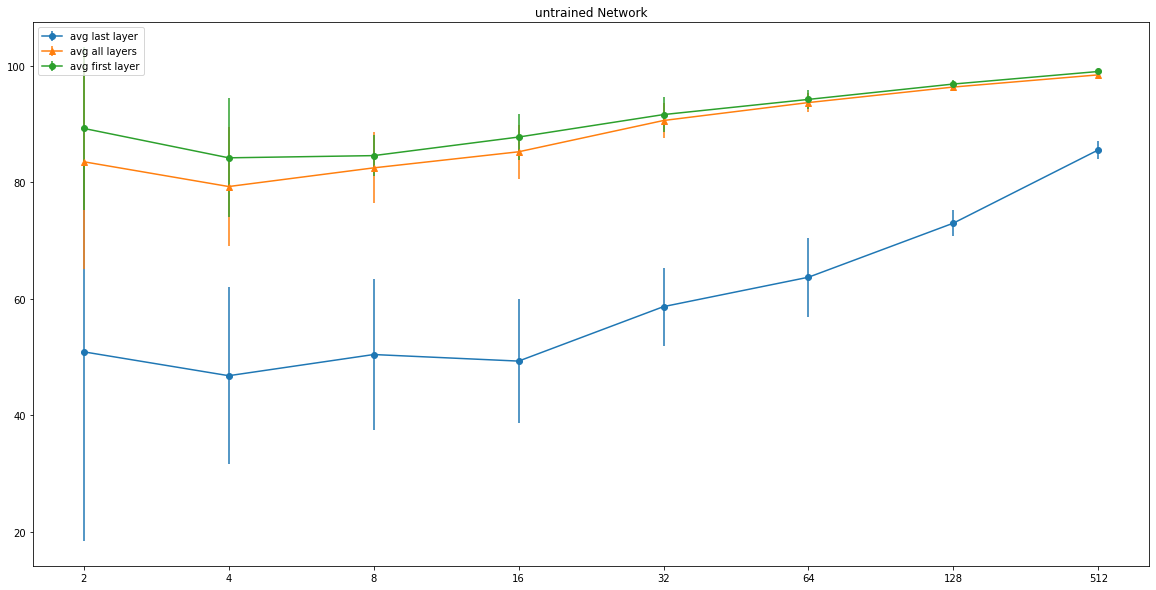

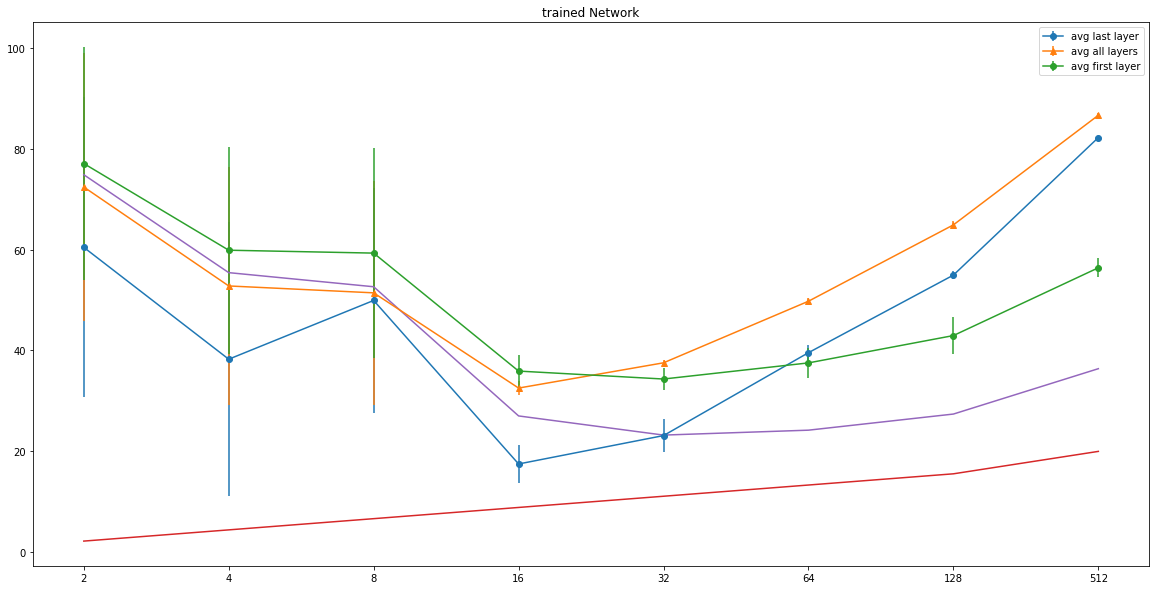

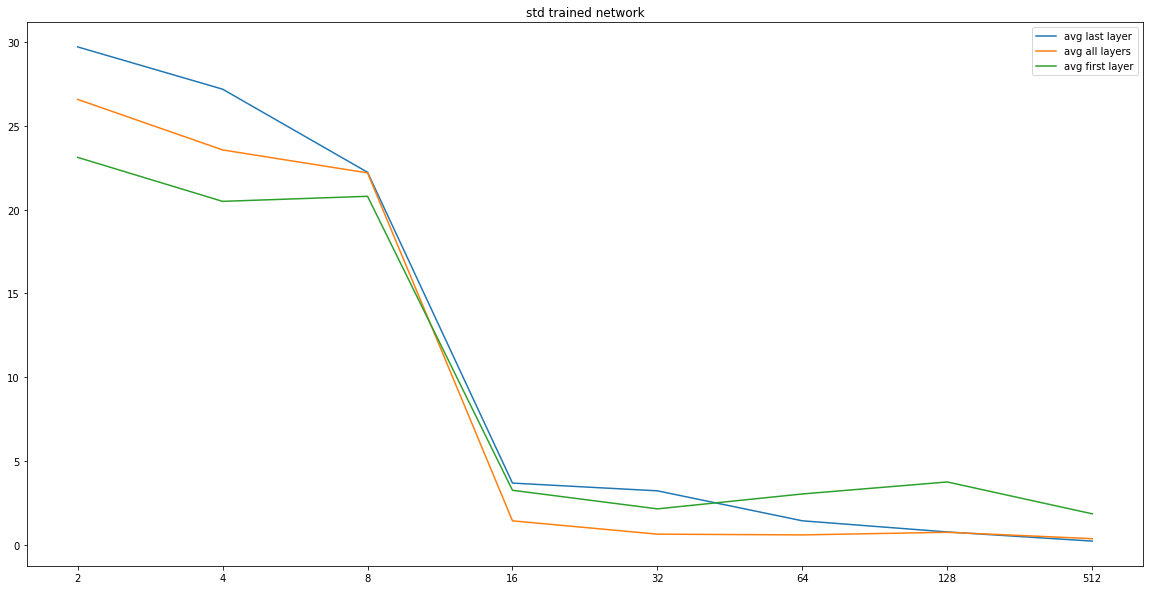

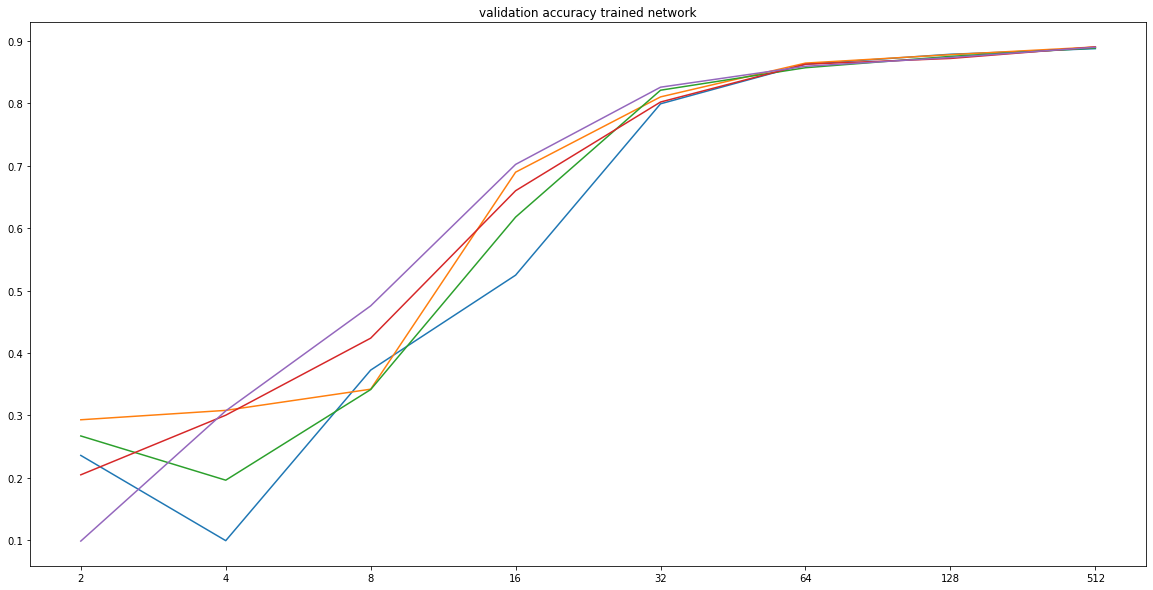

In [267]:
fig = plt.errorbar(wd[::-1], cifar10llmean_u[::-1], cifar10llstd_u[::-1], linestyle = 'solid',fmt='o')
fig.set_label('avg last layer')
fig = plt.errorbar(wd[::-1], cifar10avgmean_u[::-1], cifar10avgstd_u[::-1], marker='^')
fig.set_label('avg all layers')
fig = plt.errorbar(wd[::-1], cifar10flmean_u[::-1], cifar10flstd_u[::-1], linestyle = 'solid',fmt='o')
fig.set_label('avg first layer')
plt.title('untrained Network')
plt.legend()
plt.show()

fig = plt.errorbar(wd[::-1], cifar10llmean[::-1], cifar10llstd[::-1], linestyle = 'solid', fmt='o', capthick=2)
fig.set_label('avg last layer')
fig = plt.errorbar(wd[::-1], cifar10avgmean[::-1], cifar10avgstd[::-1], marker='^')
fig.set_label('avg all layers')
fig = plt.errorbar(wd[::-1], cifar10flmean[::-1], cifar10flstd[::-1], linestyle = 'solid', fmt='o', capthick=2)
fig.set_label('avg first layer')
plt.title('trained Network')
x = [int(y) for y in wd[::-1]]
x = np.array(x)
x = np.log2(x)
x = 0.2*x*100/np.log2(512)
plt.plot(wd[::-1], x)
plt.plot(wd[::-1], cifar10flmean[::-1] - x)
plt.legend()
plt.show()

fig, = plt.plot(wd[::-1], cifar10llstd[::-1])
fig.set_label('avg last layer')
fig, = plt.plot(wd[::-1],cifar10avgstd[::-1])
fig.set_label('avg all layers')
fig, = plt.plot(wd[::-1], cifar10flstd[::-1])
fig.set_label('avg first layer')
plt.title('std trained network')
plt.legend()
plt.show()

plt.plot(wd[::-1], cifar10acc20[::-1])
plt.plot(wd[::-1], cifar10acc21[::-1])
plt.plot(wd[::-1], cifar10acc22[::-1])
plt.plot(wd[::-1], cifar10acc23[::-1])
plt.plot(wd[::-1], cifar10acc24[::-1])
plt.title('validation accuracy trained network')
plt.show()

## SVHN

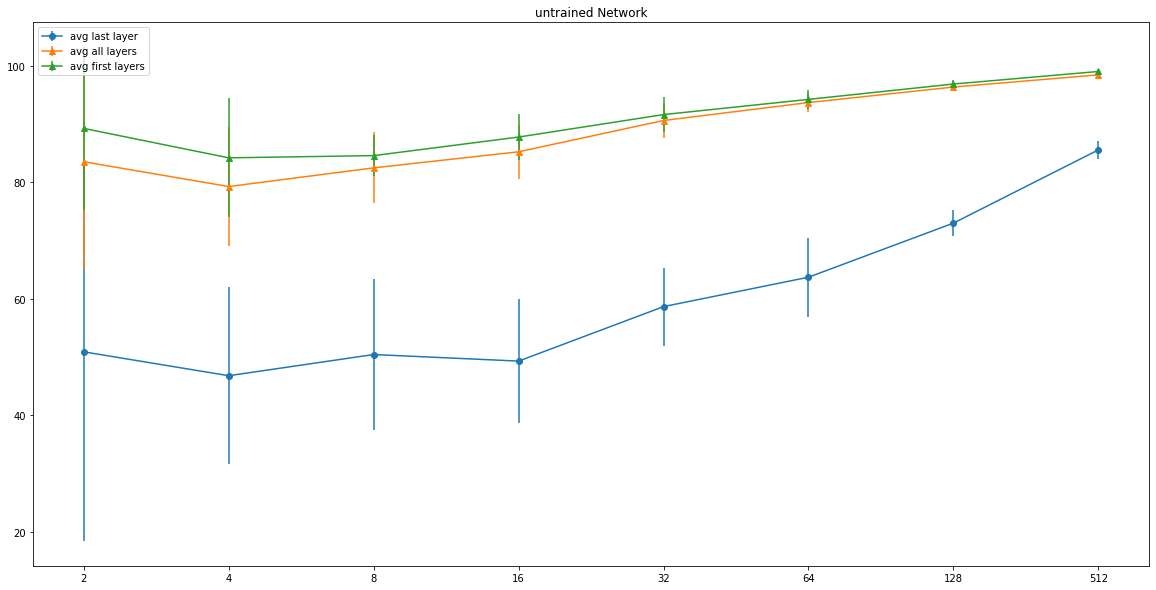

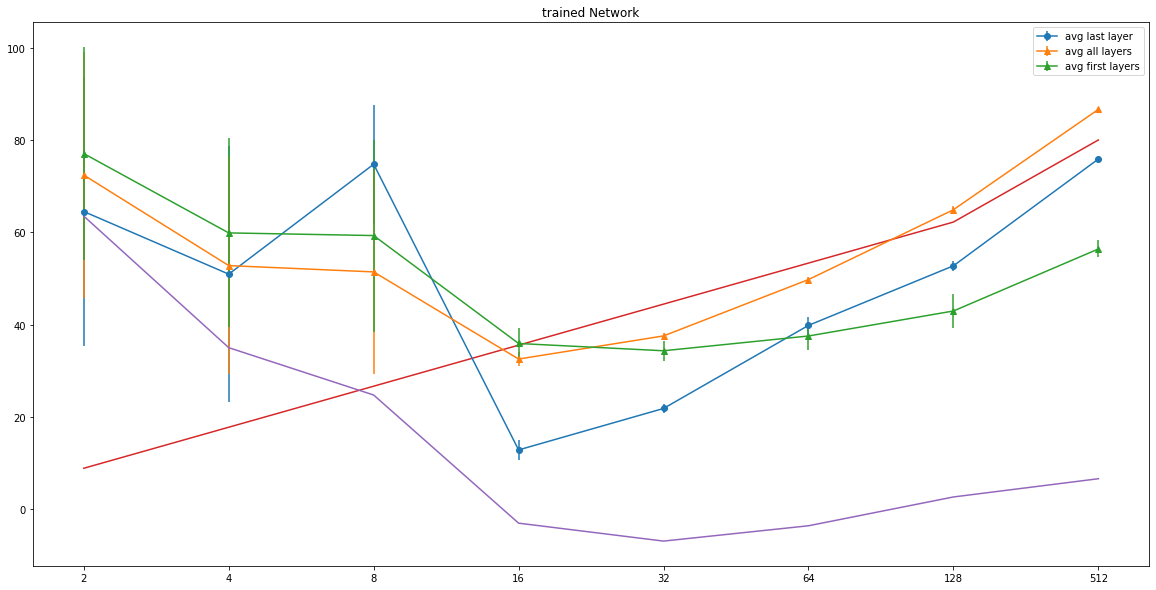

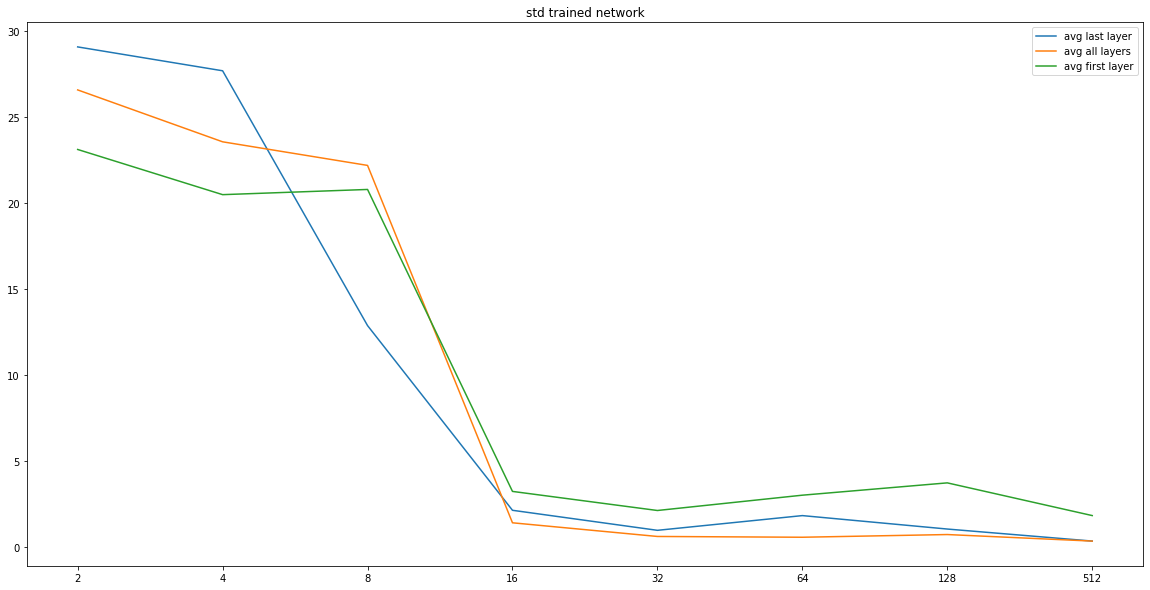

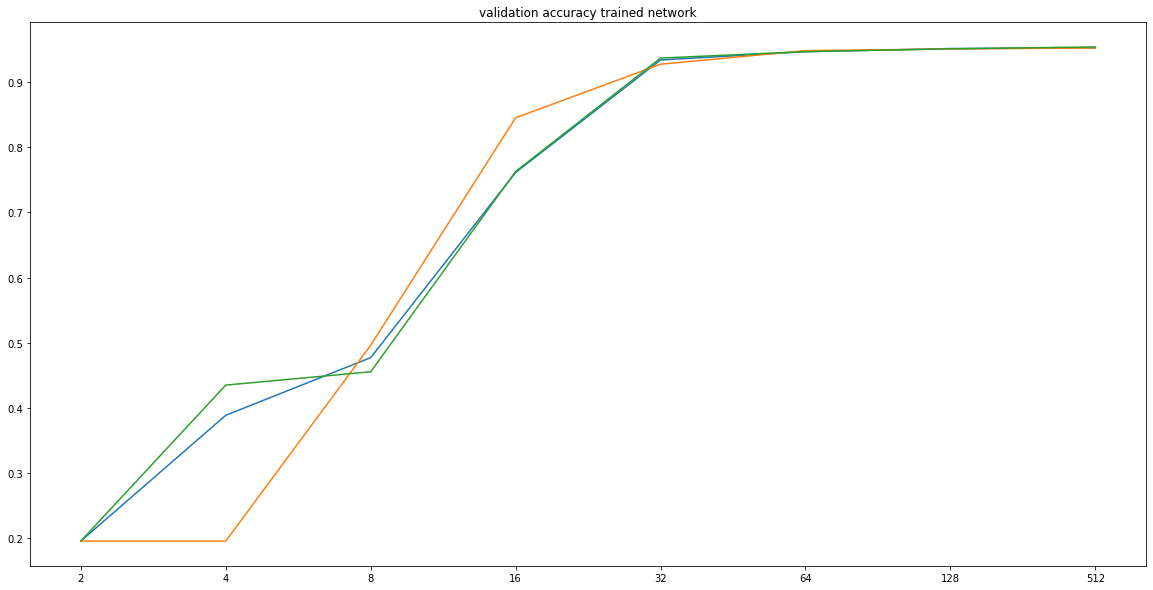

In [262]:
fig = plt.errorbar(wd[::-1], svhnllmean_u[::-1], svhnllstd_u[::-1], linestyle = 'solid',fmt='o')
fig.set_label('avg last layer')
fig = plt.errorbar(wd[::-1], svhnavgmean_u[::-1], svhnavgstd_u[::-1], marker='^')
fig.set_label('avg all layers')
fig = plt.errorbar(wd[::-1], svhnflmean_u[::-1], svhnflstd_u[::-1], marker='^')
fig.set_label('avg first layers')
plt.title('untrained Network')
plt.legend()
plt.show()

fig = plt.errorbar(wd[::-1], svhnllmean[::-1], svhnllstd[::-1], linestyle = 'solid', fmt='o', capthick=2)
fig.set_label('avg last layer')
fig = plt.errorbar(wd[::-1], svhnavgmean[::-1], svhnavgstd[::-1], marker='^')
fig.set_label('avg all layers')
fig = plt.errorbar(wd[::-1], svhnflmean[::-1], svhnflstd[::-1], marker='^')
fig.set_label('avg first layers')
plt.title('trained Network')
x = [int(y) for y in wd[::-1]]
x = np.array(x)
x = np.log2(x)
x = 0.8*x*100/np.log2(512)

plt.plot(wd[::-1], x)
plt.plot(wd[::-1], svhnavgmean[::-1] - x)
plt.legend()
plt.show()
fig, = plt.plot(wd[::-1], svhnllstd[::-1])
fig.set_label('avg last layer')
fig, = plt.plot(wd[::-1],svhnavgstd[::-1])
fig.set_label('avg all layers')
fig, = plt.plot(wd[::-1], svhnflstd[::-1])
fig.set_label('avg first layer')
plt.title('std trained network')
plt.legend()
plt.show()
plt.plot(wd[::-1], svhnacc20[::-1])
plt.plot(wd[::-1], svhnacc21[::-1])
plt.plot(wd[::-1], svhnacc22[::-1])
#plt.plot(wd[::-1], cifar10acc23[::-1])
#plt.plot(wd[::-1], cifar10acc24[::-1])
plt.title('validation accuracy trained network')
plt.show()

## CIFAR100

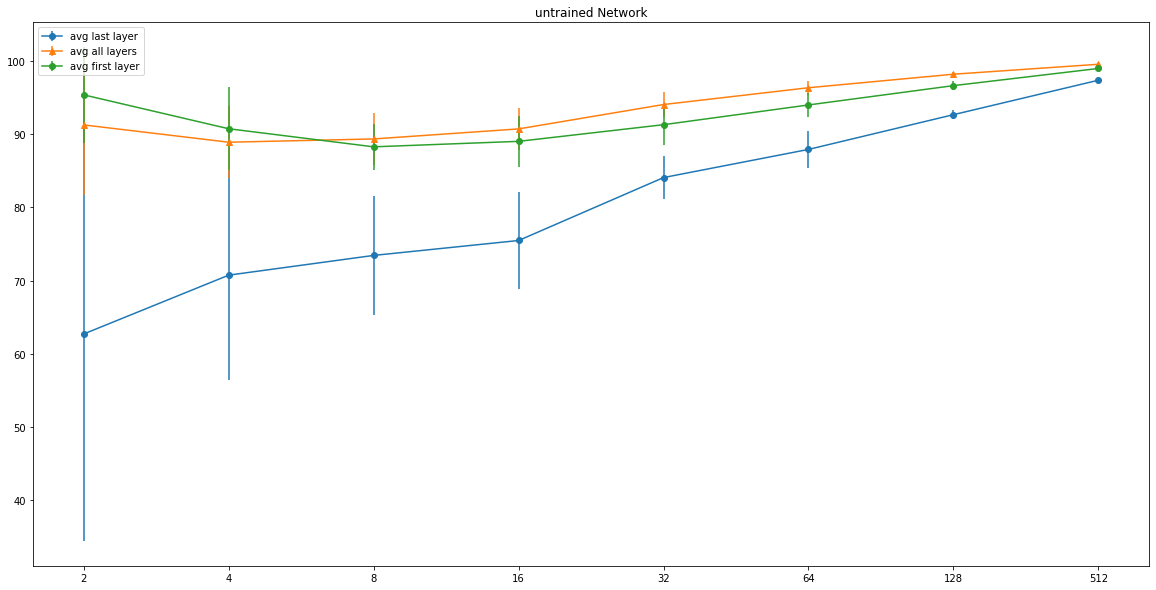

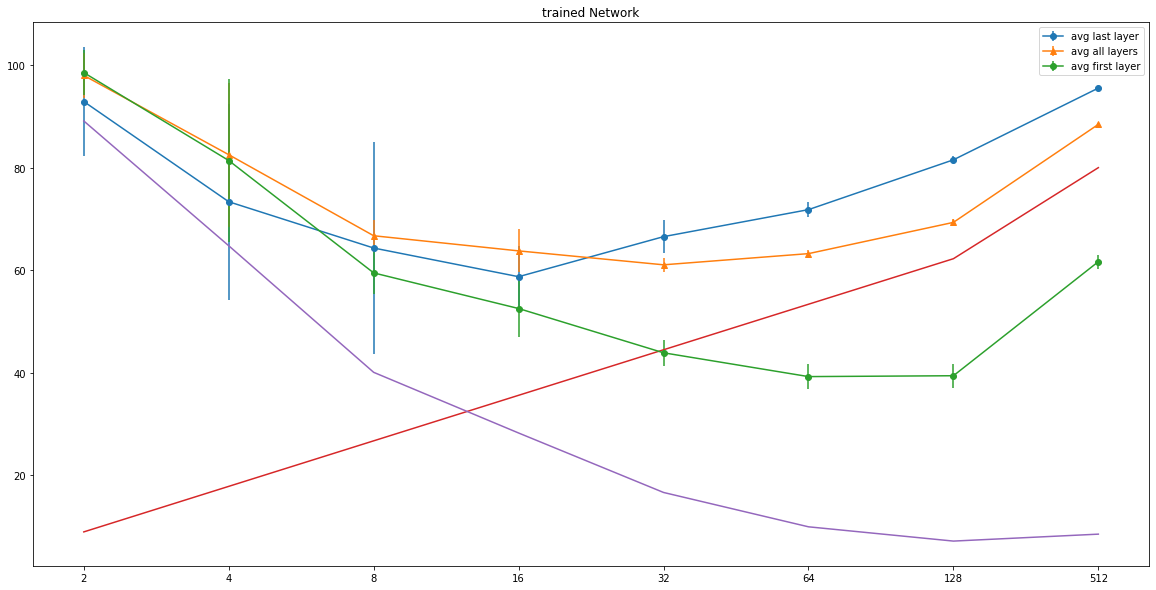

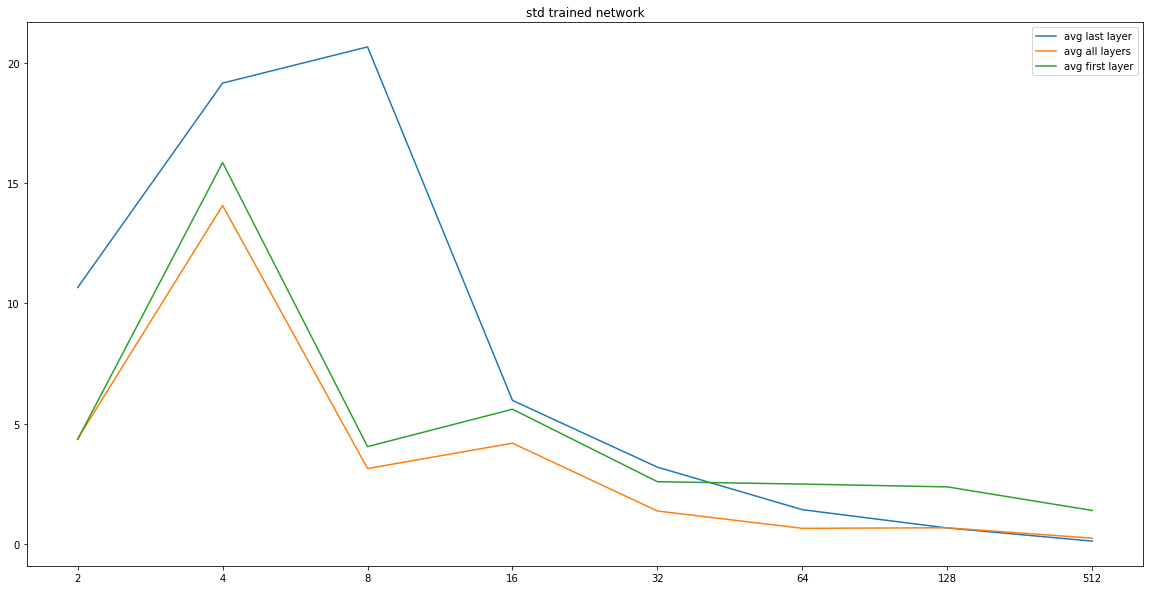

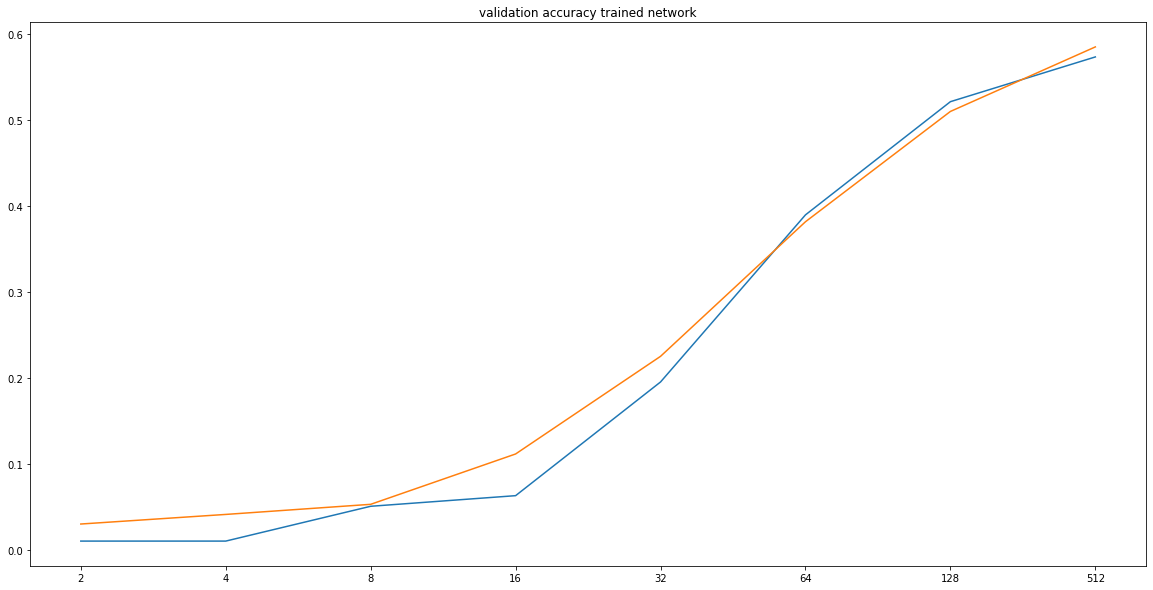

In [261]:
fig = plt.errorbar(wd[::-1], cifar100llmean_u[::-1], cifar100llstd_u[::-1], linestyle = 'solid',fmt='o')
fig.set_label('avg last layer')
fig = plt.errorbar(wd[::-1], cifar100avgmean_u[::-1], cifar100avgstd_u[::-1], marker='^')
fig.set_label('avg all layers')
fig = plt.errorbar(wd[::-1], cifar100flmean_u[::-1], cifar100flstd_u[::-1], linestyle = 'solid',fmt='o')
fig.set_label('avg first layer')
plt.title('untrained Network')
plt.legend()
plt.show()

fig = plt.errorbar(wd[::-1], cifar100llmean[::-1], cifar100llstd[::-1], linestyle = 'solid', fmt='o', capthick=2)
fig.set_label('avg last layer')
fig = plt.errorbar(wd[::-1], cifar100avgmean[::-1], cifar100avgstd[::-1], marker='^')
fig.set_label('avg all layers')
fig = plt.errorbar(wd[::-1], cifar100flmean[::-1], cifar100flstd[::-1], linestyle = 'solid', fmt='o', capthick=2)
fig.set_label('avg first layer')
plt.title('trained Network')
x = [int(y) for y in wd[::-1]]
x = np.array(x)
x = np.log2(x)
x = 0.8*x*100/np.log2(512)

plt.plot(wd[::-1], x)
plt.plot(wd[::-1], cifar100avgmean[::-1] - x)
plt.legend()
plt.show()
fig, = plt.plot(wd[::-1], cifar100llstd[::-1])
fig.set_label('avg last layer')
fig, = plt.plot(wd[::-1],cifar100avgstd[::-1])
fig.set_label('avg all layers')
fig, = plt.plot(wd[::-1], cifar100flstd[::-1])
fig.set_label('avg first layer')
plt.title('std trained network')
plt.legend()
plt.show()
plt.plot(wd[::-1], cifar100acc20[::-1])
plt.plot(wd[::-1], cifar100acc21[::-1])
#plt.plot(wd[::-1], cifar100acc22[::-1])
#plt.plot(wd[::-1], cifar10acc23[::-1])
#plt.plot(wd[::-1], cifar10acc24[::-1])

plt.title('validation accuracy trained network')
plt.show()

# PLOTS uncertaint accuracy width

In [20]:
wd = ['512','128','64','32','16','8','4','2']

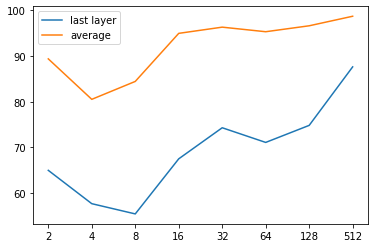

In [38]:
fig, = plt.plot(wd[::-1], cifar10ll_untr[::-1])
fig.set_label('last layer')
fig, = plt.plot(wd[::-1], cifar10avg_untr[::-1])
fig.set_label('average')
plt.legend()
plt.show()

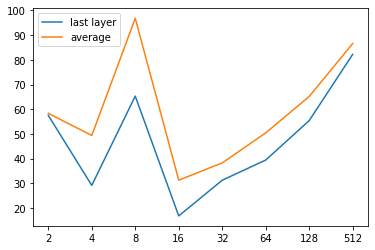

In [39]:
fig, = plt.plot(wd[::-1], cifar10ll[::-1])
fig.set_label('last layer')
fig, = plt.plot(wd[::-1], cifar10avg[::-1])
fig.set_label('average')
plt.legend()
plt.show()

## SVHN

### width against accuracy

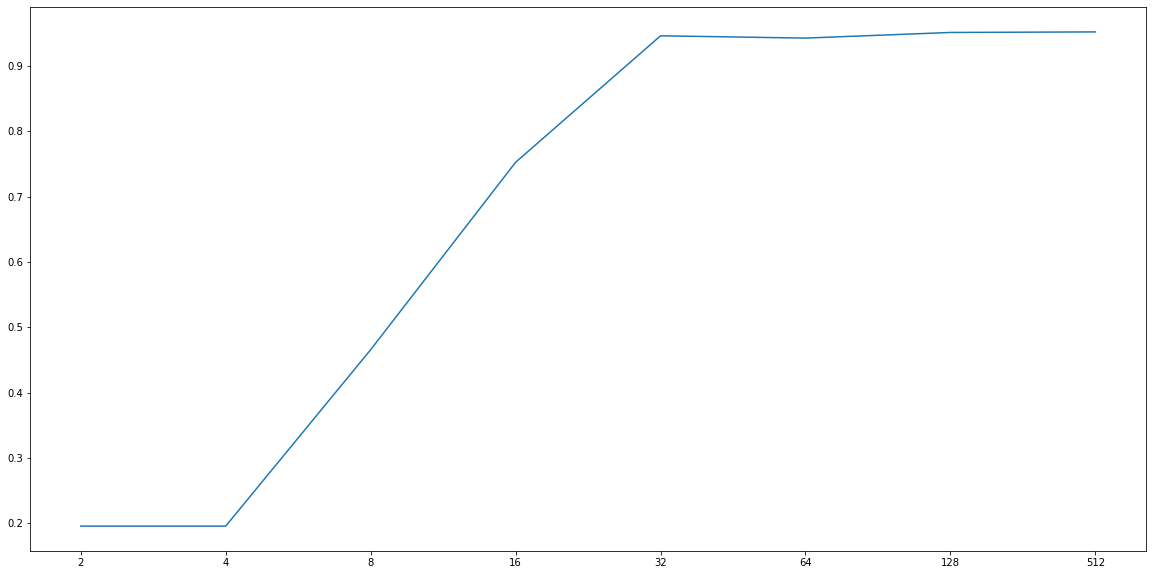

In [115]:
plt.plot(wd[::-1], acc_svhn[::-1])

### width against uncertainty

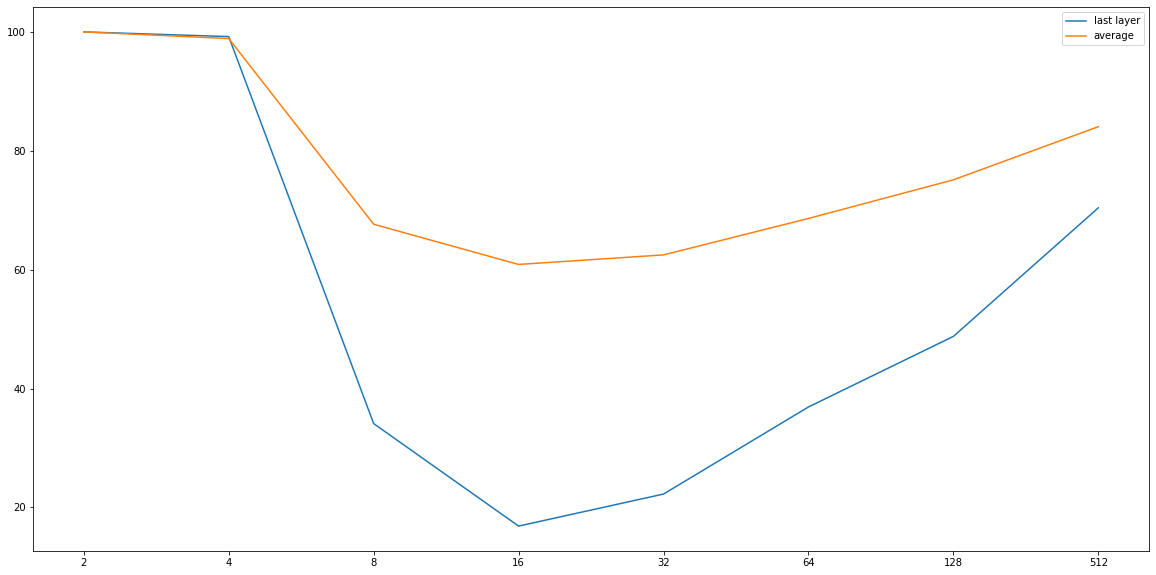

In [145]:
fig, = plt.plot(wd[::-1], lastlayer_unc_svhn[::-1])
fig.set_label('last layer')
fig, = plt.plot(wd[::-1], avg_unc_svhn[::-1])
fig.set_label('average')
plt.legend()
plt.show()

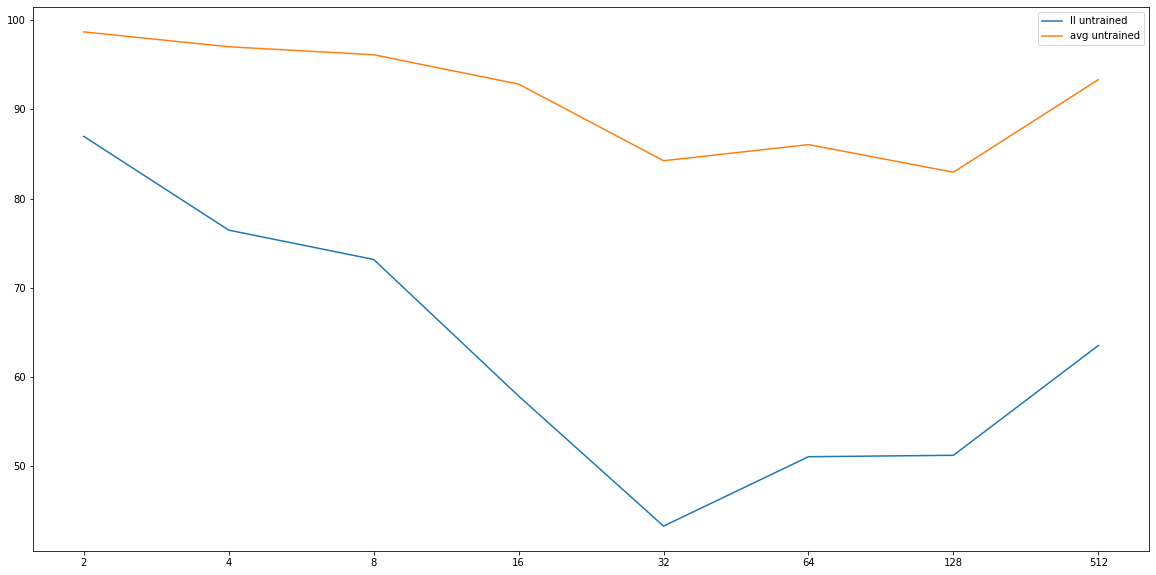

In [150]:
fig, = plt.plot(wd[::-1], lastlayer_unc_svhnx_untrained)
fig.set_label('ll untrained')
fig, = plt.plot(wd[::-1], avg_unc_svhnx_untrained)
fig.set_label('avg untrained')
plt.legend()
plt.show()

### width against weightsize

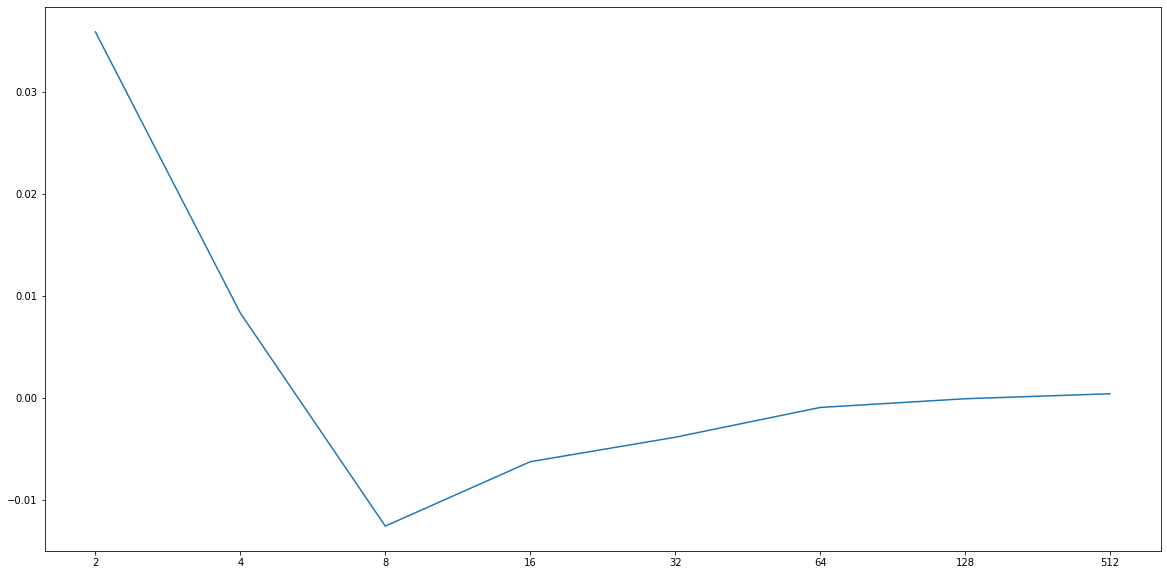

In [114]:
plt.plot(wd[::-1], weightsize_svhn[::-1])

## CIFAR10

### width against accuracy

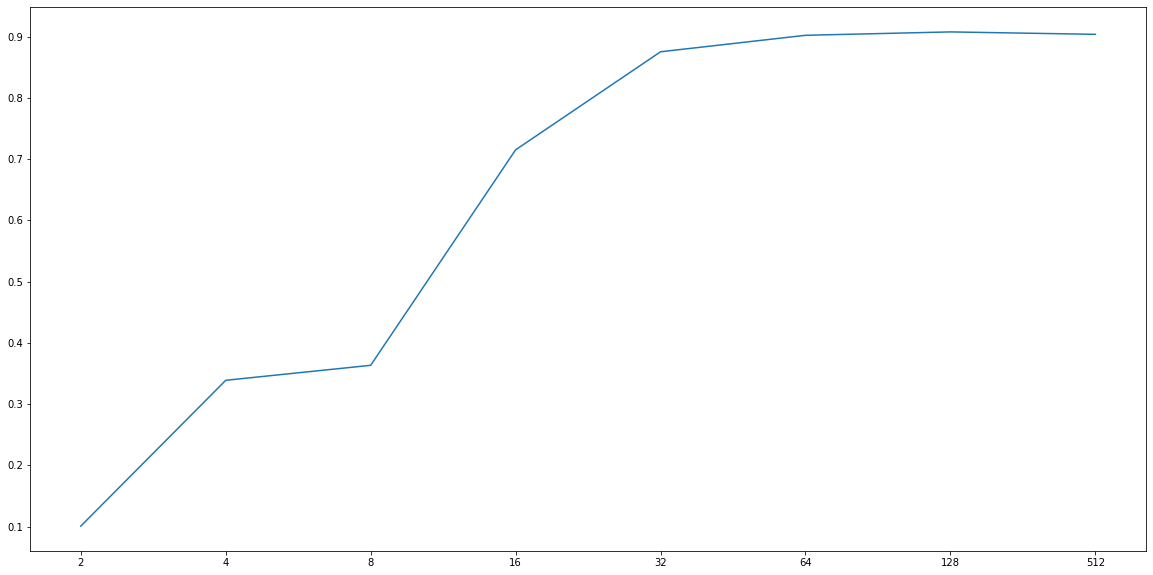

In [116]:
plt.plot(wd[::-1], acc_cifar10[::-1])

### width against uncertainty

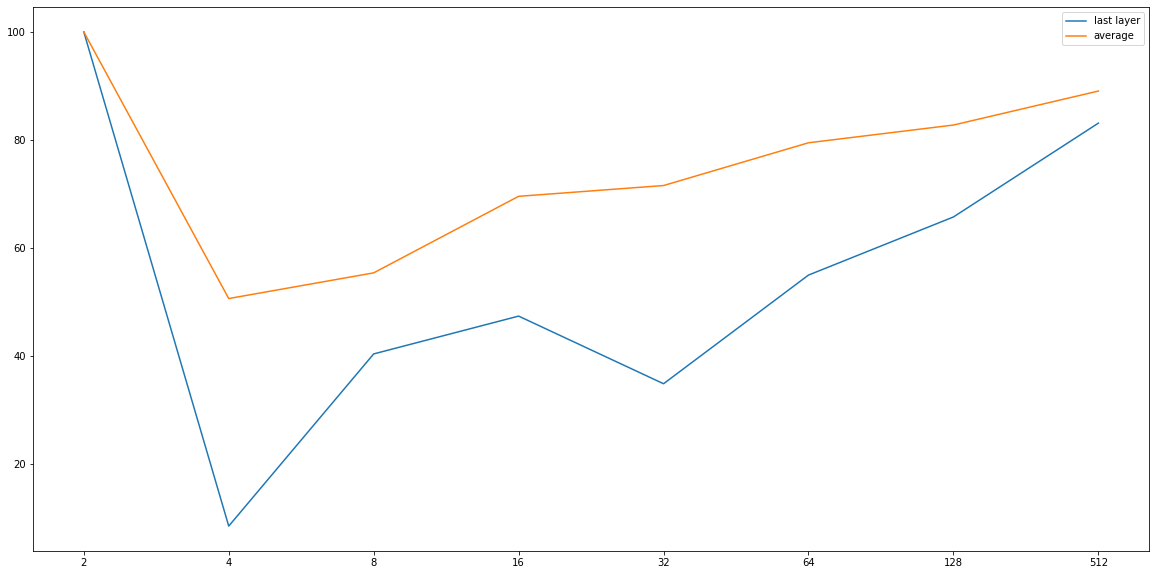

In [149]:
fig, = plt.plot(wd[::-1], lastlayer_unc_cifar10[::-1])
fig.set_label('last layer')
fig, = plt.plot(wd[::-1], avg_unc_cifar10[::-1])
fig.set_label('average')
plt.legend()
plt.show()

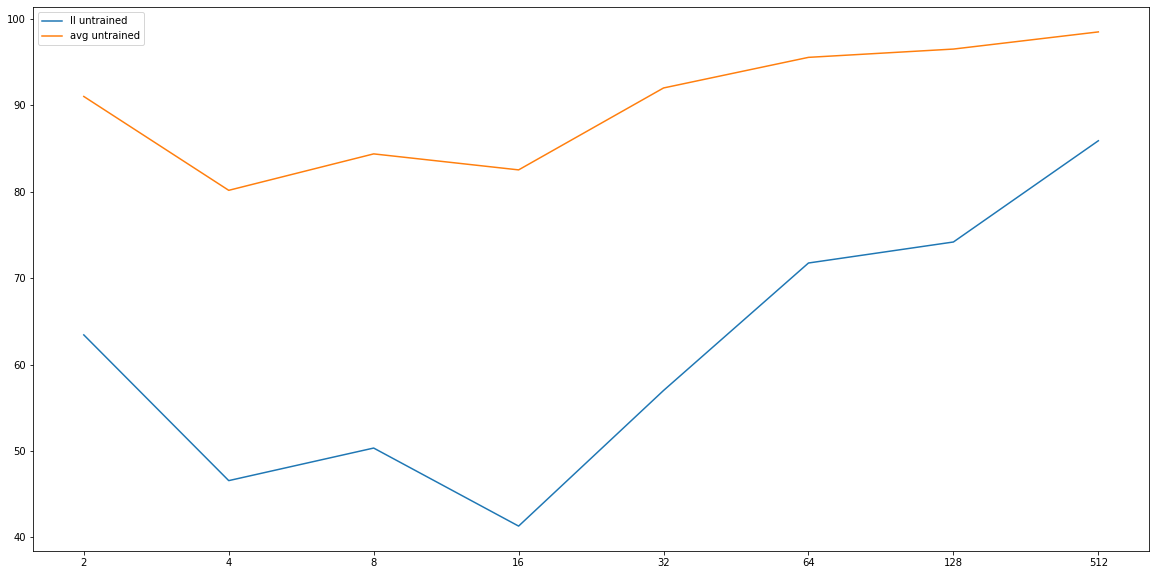

In [155]:
fig, = plt.plot(wd[::-1], lastlayer_unc_cifar10_untrained[::-1])
fig.set_label('ll untrained')
fig, = plt.plot(wd[::-1], avg_unc_cifar10_untrained[::-1])
fig.set_label('avg untrained')
plt.legend()
plt.show()

### width against weightsize

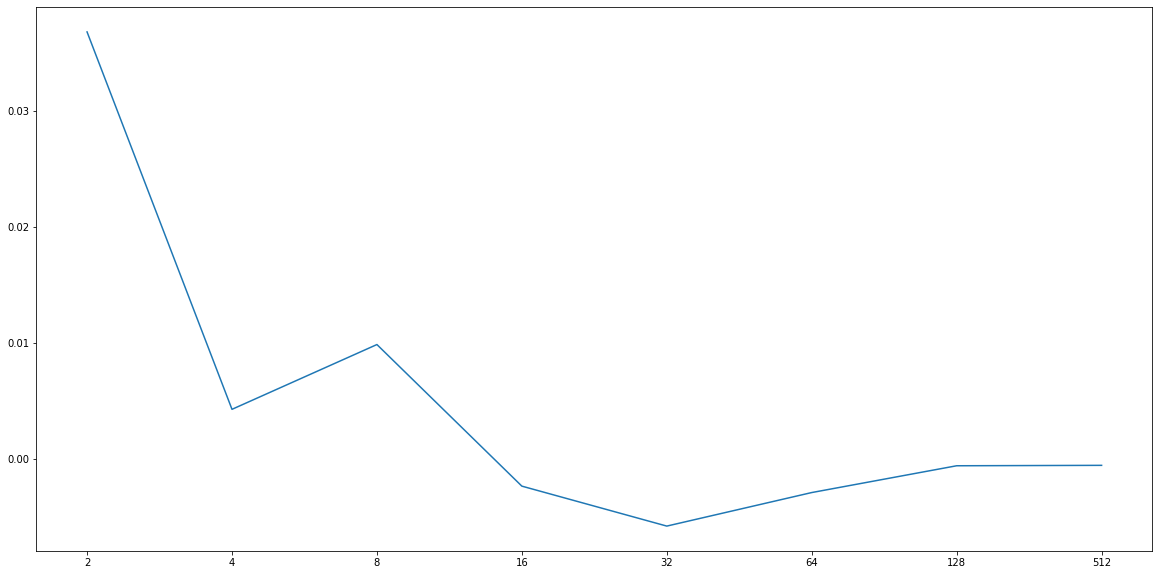

In [118]:
plt.plot(wd[::-1], weightsize_cifar10[::-1])

## CIFAR100

### width against accuracy

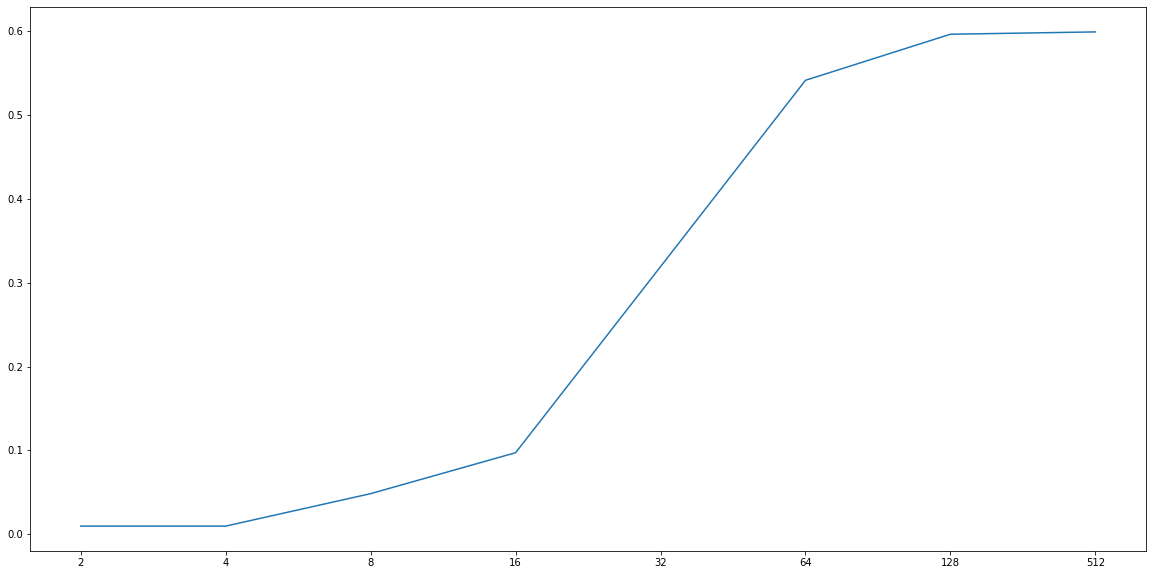

In [119]:
plt.plot(wd[::-1], acc_cifar100[::-1])

### width against uncertainty

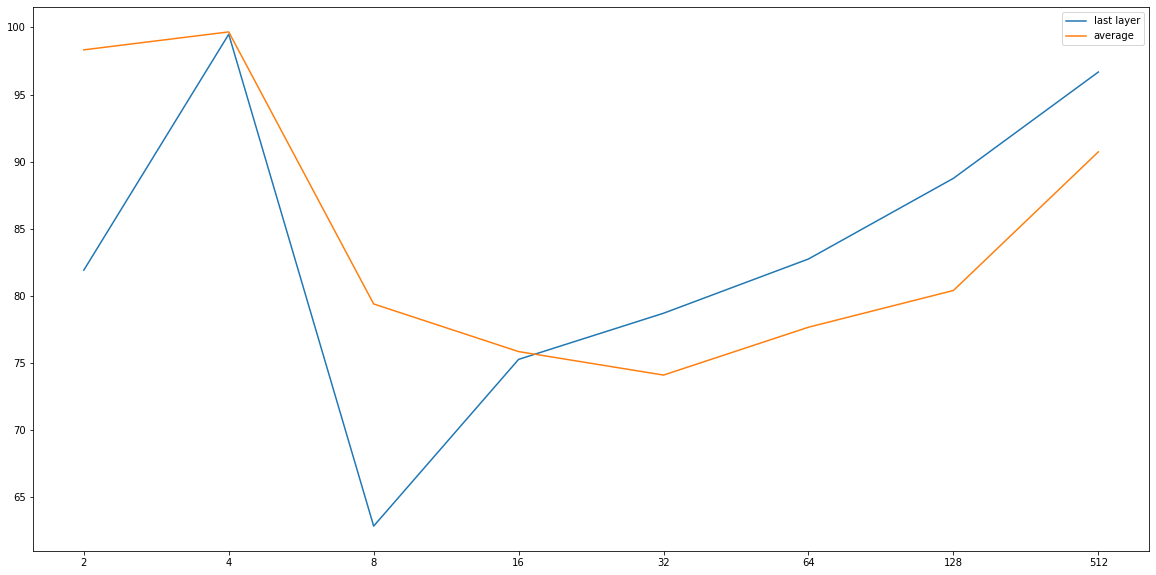

In [120]:
fig, = plt.plot(wd[::-1], lastlayer_unc_cifar100[::-1])
fig.set_label('last layer')
fig, = plt.plot(wd[::-1], avg_unc_cifar100[::-1])
fig.set_label('average')
plt.legend()
plt.show()

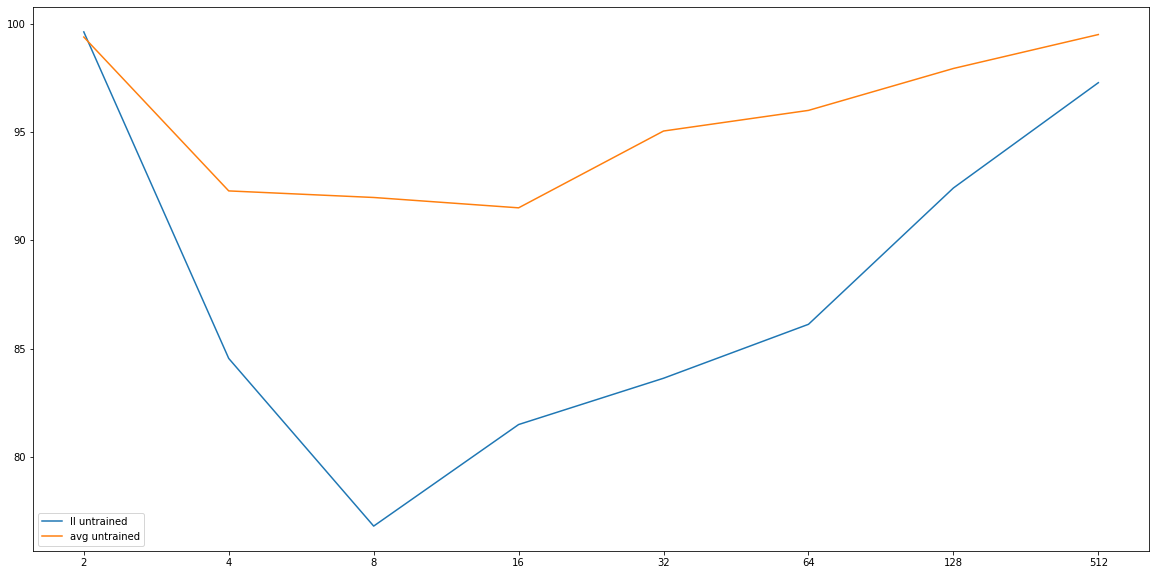

In [159]:
fig, = plt.plot(wd[::-1], lastlayer_unc_cifar100_untrained[::-1])
fig.set_label('ll untrained')
fig, = plt.plot(wd[::-1], avg_unc_cifar100_untrained[::-1])
fig.set_label('avg untrained')
plt.legend()
plt.show()

### width against weightsize

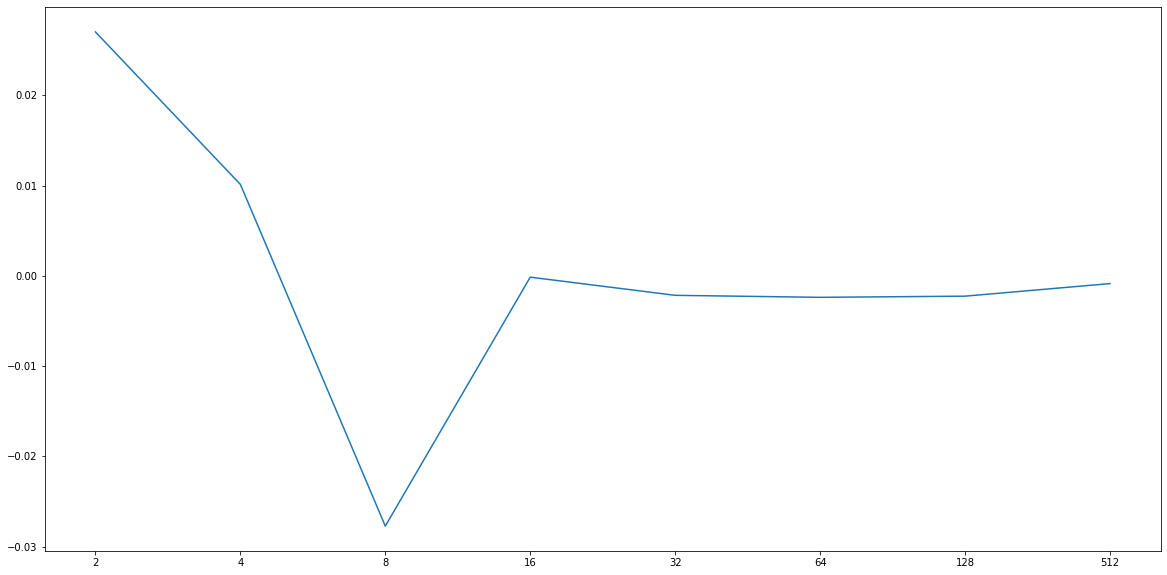

In [121]:
plt.plot(wd[::-1], weightsize_cifar100[::-1])

## uncertainty against accuary (SVHN, CIFAR10, CIFAR100 respectively)

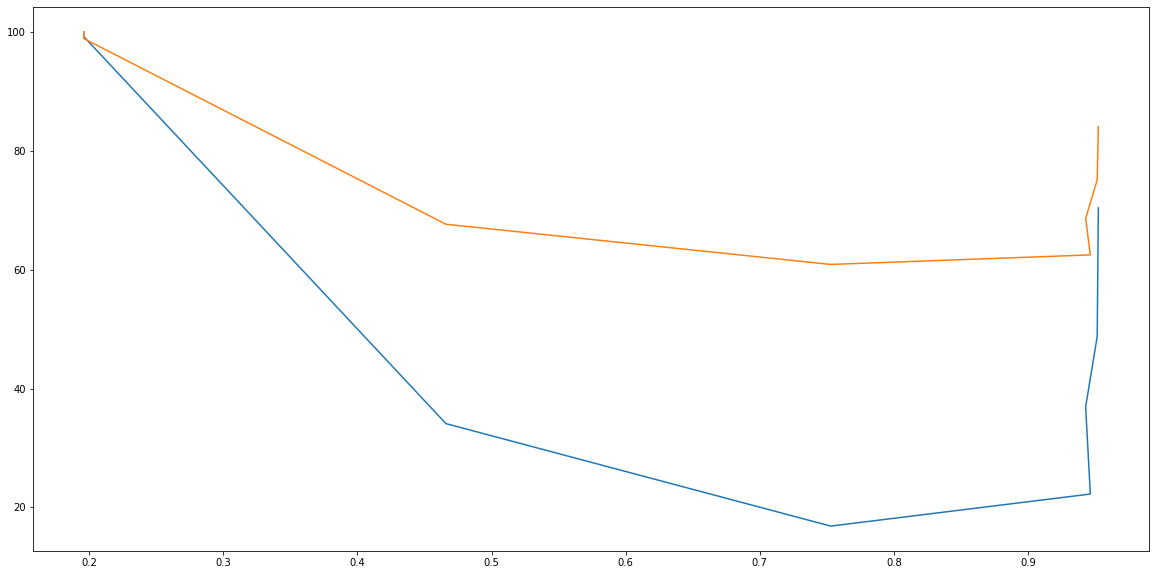

In [137]:
plt.plot(acc_svhn[::-1], lastlayer_unc_svhn[::-1])
plt.plot(acc_svhn[::-1], avg_unc_svhn[::-1])

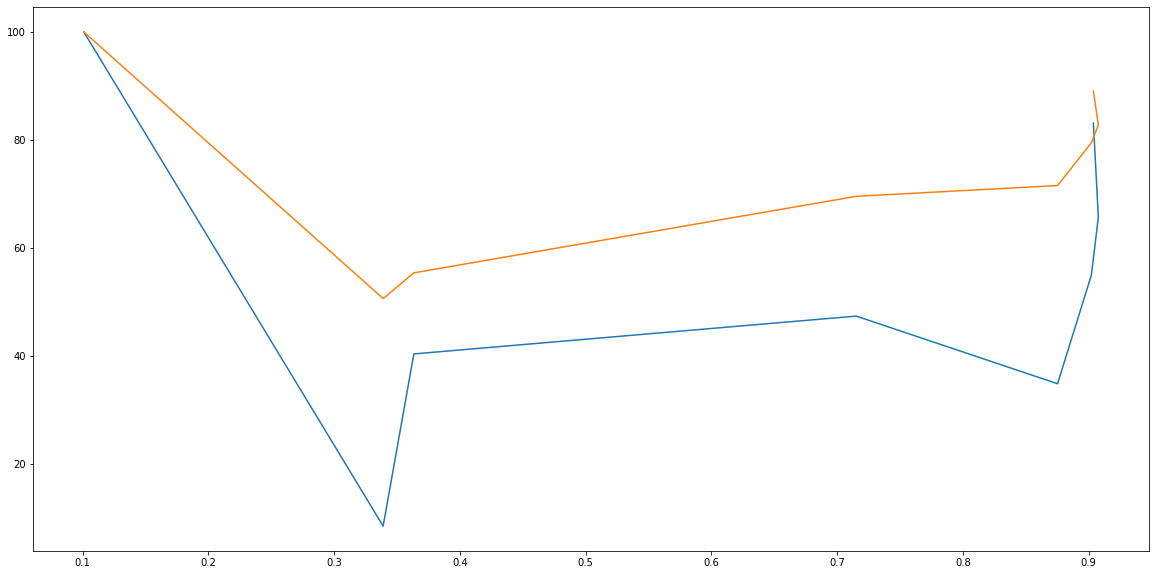

In [138]:
plt.plot(acc_cifar10[::-1], lastlayer_unc_cifar10[::-1])
plt.plot(acc_cifar10[::-1], avg_unc_cifar10[::-1])

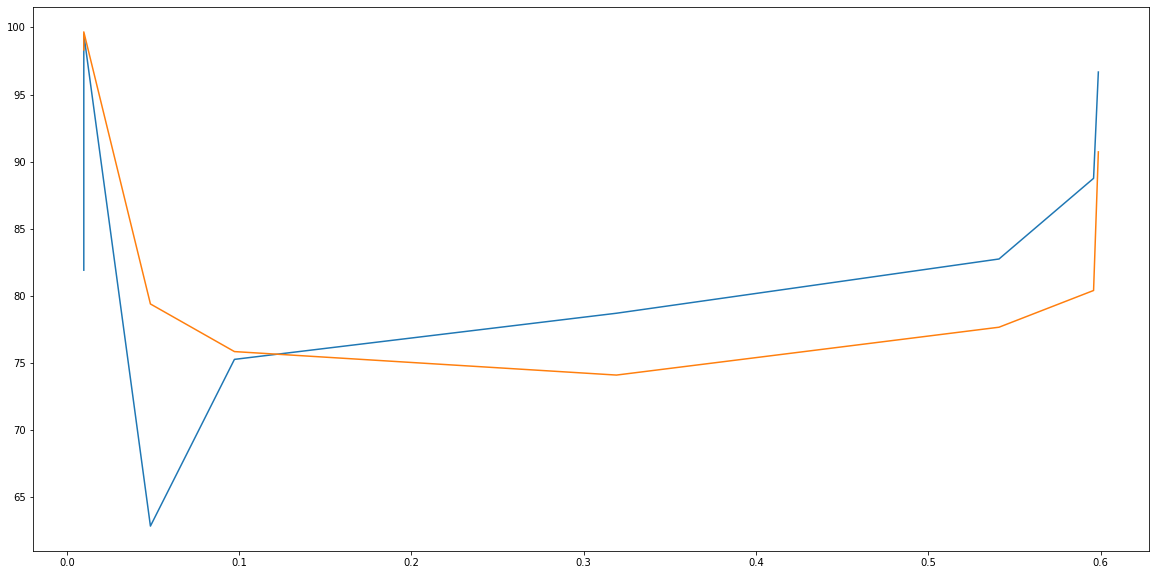

In [140]:
plt.plot(acc_cifar100[::-1], lastlayer_unc_cifar100[::-1])
plt.plot(acc_cifar100[::-1], avg_unc_cifar100[::-1])